<div style="width: 80%; display: flex; justify-content: flex-start; align-items: center; margin-left: 20%;">
    <img src="https://docs.classiq.io/resources/classiq-logo.svg" alt="classiq_logo" width="400" height="auto" style="margin-right: 50px;" />
    <img src="https://docs.classiq.io/resources/pushquantum_logo.png" alt="pushquantum_logo" width="400" height="auto" />
</div>

# Classiq Challange: Estimating Molecular Spectra Using the Rodeo Algorithm

Welcome to the Classiq challenge of the 2024 PushQuantum Hackathon!
This Jupyter notebook is the framework for the challenge and you should follow it in order to solve it using Classiq.

The notebook has 2 parts:
1. A warm-up session, just to get up to speed with a small example of Classiq
2. The challenge itself, including what you need to create, what's the format, and how you can check yourself

Additional resources you should use are
- The IDE of the classiq platform at [platform.classiq.io](https://platform.classiq.io/)
- The [community Slack of Classiq](https://short.classiq.io/join-slack) - Classiq's team will answer any question you have over there, including implementation questions
- [Classiq's documentation](https://docs.classiq.io/latest/) with the dedicated:
    - [Classiq 101](https://docs.classiq.io/latest/classiq_101/)
    -  [Python SDK Reference](https://docs.classiq.io/latest/sdk-reference/)
    -  [Our GitHub Repostory](https://github.com/Classiq/classiq-library)

Good luck!

### Challenge's Abstract

Estimating the energy eigenvalues of a Hamiltonian is a fundamental task in quantum chemistry, material science and condensed matter physics. These eigenvalues provide critical insights into the underlying system, whether it be a molecule, material, or a more general quantum system. Many applications are based on the accurate estimation on the accurate estimation of the energy values like photodynamic therapy for cancer treatment, molecular drug design, and development of efficient energy storage devices.

Quantum computers main advantage will arguably be 'to simulate nature', thus they might offer a crucial advantage in estimating the energy values of Hamiltonians representing molecules, proteins, and materials. 

The [Rodeo Algorithm](https://arxiv.org/pdf/2009.04092) is a quantum algorithm for estimating the energy eigenvalues of any given Hamiltonian within a specified energy interval. In this challenge, you will implement it using the Classiq platform! Specifically for this challenge, the Rodeo algorithm is used to solve molecular Hamiltonians.

Roughly Speaking, the Rodeo Algorithm filters linearly spaced discrete sets of energies within a given interval, isolating and refining the true eigenvalues of the Hamiltonian. The algorithm can accurately identify energy levels by iteratively "sweeping" through the energy spectrum, making it a practical approach for quantum computations.

This challenge provides an opportunity to implement a state-of-the-art quantum algorithm, bridging theoretical concepts with real-world applications in quantum computing.

This is a scheme of the Rodeo Algorithm:

<div style="text-align: center;">
    <img src="https://docs.classiq.io/resources/rodeo2.png" alt="Rodeo.png" width="600" />
</div>

<p style="text-align: center;">
Fig.1 from the original paper: <a href="https://arxiv.org/pdf/2009.04092">Rodeo Algorithm for Quantum Computing</a> by Kenneth Choi et al.
</p>

### Make Sure You Are Ready to Go

If you haven't done it yet, try running the following lines of code and use the [regestration and installation](https://docs.classiq.io/latest/classiq_101/registration_installations/) page if you are having difficulty setting up your environment.\
Uncomment and run the following command to install or update to the latest version of the Classiq SDK (if not installed yet):

Uncomment and run the following command if your machine has not been authenticated yet:

In [1]:
import classiq
from classiq import *
from classiq.execution import ExecutionSession,ExecutionJob
from classiq.execution import (
    ClassiqBackendPreferences,
    ClassiqSimulatorBackendNames,
    ExecutionPreferences, 
)

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
classiq.authenticate()


c:\Users\Marc\anaconda3\envs\classiq-env\lib\site-packages\classiq\_internals\authentication\token_manager.py:101: UserWarning: Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true
  warnings.warn(


## Challenge Warm-Up

A quick warm-up task will ensure you are ready to dive into the challenge confidently. Here’s what you need to do:

1. Create a `qfunc` named `prep`:
   - This function should prepare the $|-\rangle$ state, assuming the input state is $|0\rangle$.

2. Create a `qfunc` named `trotter`:
   - This function should utilize the `suzuki_trotter()` method.
   - Inputs: A variable of the type `QArray[QBit]`.
   - Implementation details:
     - Call the `suzuki_trotter()` function with the following parameters:
       - `HAMILTONIAN`: Use the given dummy Hamiltonian.
       - `evolution_coefficient`: Set to 1.
       - `order`: Set to 1.
       - `repetitions`: Set to 30.
       - `qbv`: Pass the declared quantum variable.

3. Create a `main` function:
   - This function should:
     - Use the `prep` function to prepare an auxiliary qubit named `aux` in the $|-\rangle$ state.
     - Use the auxiliary qubit as a `control` for the `trotter` function, which should act on another qubit. (Read more on `control`:[here](https://docs.classiq.io/latest/qmod-reference/language-reference/statements/control/?h=control))
     - Finally, apply an `H` gate on the auxiliary qubit.

By completing this warm-up, you will practice the essential steps needed for the challenge. Take it step by step, starting simple, and then make your code robust and adaptable!

In [ ]:
N=6 # Number of ancilla qubits
sigma=10  # Sigma to sample the time
mean=0 # mean to sample the time
order=1 # order of the Suzuki-Trotter decomposition
repetitions=30 # Number of repetitions of the Suzuki Trotter

@qfunc
def controlled_trotter(HAMILTONIAN: CArray[PauliTerm], ancilla: QBit, state: QArray[QBit], E: CReal, t_k: CReal)-> None:
    '''
    This function will perform the Hamiltonian evolution on the state registers controlled by one ancilla register. After performing this conditional
    Hamiltonian evolution, it will apply the Phase gate.
    Args:
        - HAMILTONIAN (CArray[PauliTerm]) : Hamiltonian to perform the time evolution.
        - ancillas (QArray[QBit]) : Ancilla qubit where it will serve as the control operation.
        - state (QArray[QBit]) : State qubits where we will apply the time evolution operator.
        - E (CReal): Energy parameter.
        - t_k (CReal): Random time sampled from a Gaussian distribution.
    Returns:
    '''
    
    
    # Hamiltonian evolution
    control(
        ancilla, 
        lambda: suzuki_trotter(
            HAMILTONIAN,
            evolution_coefficient=t_k, 
            order=order,
            repetitions=repetitions, 
            qbv=state,
        )
    )

    # Phase
    PHASE(E * t_k, ancilla)

@qfunc
def X_transform(ancillas:QArray[QBit])->None:
    ''' 
    This function will apply the X gate to the ancillas qubits.
    Args:
        -ancillas (QArray[QBit]) : Ancilla qubits where they will serve as the control operation. 
    '''

    repeat( count=ancillas.len,
            iteration= lambda i : X(ancillas[i]))
    


def rodeo_algorithm(HAMILTONIAN: CArray[PauliTerm], ancillas: QArray[QBit], state: QArray[QBit], E: CReal, t:CArray[CReal]) -> None:
    '''
    This function applies one iteration of the Rodea Algorithm (see : https://arxiv.org/pdf/2009.04092). The order of the algorithm is as follows
    1- Apply the X gate to the ancillas qubits.
    2- Apply the Hadamard on the ancillas qubits.
    3- Apply the trotter evolution on the state controlled by the ancillas qubits. After this evolution apply the phase (E*t_k) gate on the controlled ancilla.
    4- Apply the Hadamard on the ancillas qubits (uncomputation).

    Args:
        - ancillas (QArray[QBit]) : Ancilla qubit where it will serve as the control operation.
        - state (QArray[QBit]) : state qubits where we will apply the time evolution operator.
        - E (CReal): Energy parameter.
        - HAMILTONIAN (CArray[PauliTerm]) : Hamiltonian to perform the time evolution.
        - t (CArray[CReal]): Array of random times.
    Returns:
    '''
    # Put the ancillas in the 1 state
    X_transform(ancillas)

    # Apply Hadamard gate on the ancillas, -> Apply the time evolution on the state -> Apply Hadamard gate on the ancillas
    
    within_apply(within= lambda: hadamard_transform(ancillas),
                apply= lambda: (repeat(count=ancillas.len,
                            iteration= lambda i: controlled_trotter(HAMILTONIAN=HAMILTONIAN, ancilla=ancillas[i], state=state, E=E, t_k=t[i])
                                        ) 
                                )
    )
    


<details>
<summary>Preparation Task Reminder</summary>
    
This is a reminder of the preparation task provided after the workshop:

- Design your own Quantum Phase Estimation (QPE) algorithm using the Suzuki-Trotter method as the unitary.
  - Learn more about QPE: [Wiki](https://en.wikipedia.org/wiki/Quantum_phase_estimation_algorithm)
  - Refer to the Suzuki-Trotter Documentation: [Classiq Docs](https://docs.classiq.io/latest/explore/functions/qmod_library_reference/qmod_core_library/hamiltonian_evolution/suzuki_trotter/suzuki_trotter/)
- Optionally, experiment by adding an RX rotation gate to the phase register (control qubits), where the angle for the n-th rotation qubit is set to π/n.

If you've already completed these tasks, they may prove useful during the challenge. If not, consider taking this extra step to enhance your preparation. :)

</details>

While these task is not required for submission, keeping it in mind could help you adrass the more complex problem during the hackathon!

## The Challenge Itself

The challenge is composed of 2 steps:

1. In the first step, you will implement the algorithm to solve the simple Hamiltonian representing the H₂ molecule.
2. The second step will be to adapt your implementation to a more complex Hamiltonian representing the H₂O molecule

This notebook should guide you (and help you) in successfully solving the challenge.

Note that the Hamiltonians are given already in their Pauli form. Some assumptions were made to reduce the complexity and runtime for the sake of the hackathon

### Submission

You are required to submit the following:

1. Jupyter Notebook (`.ipynb`)  
    - Ensure your code and explanations are well-documented.

2. Output graphs of Averaged Energy Population Distribution (for each part of the challenge):  
    - Plot normalized population as a function of energy values.
    - Identify and mark the peaks on the graph.
    - Specify the parameters used to produce the graph.

3. Quantum program files (`.qprog`)  
   - Submit a `.qprog` file corresponding to each part of the challenge (you can use the `save_qprog` function defined below, or export it from the platform using it's GUI)

Create a `.zip` file and submit it all together in the following link: [here](https://fvrn0h72gwo.typeform.com/to/WNGZ7hIH)

In [5]:
'''def save_qprog(qprog, file_name):
    """
    A simple function that saves your quantum program (qprog) as a text file in a .qprog format.
    The function saves the qprog in the same directory as the current Python file you are working on.

    Inputs:
        - qprog: the quantum program (the returned value of the synthesize() function)
        - file_name: a string that determines the file name
    """
    file = open(file_name + ".qprog", "w")
    file.write(qprog)
    file.close()
'''

'def save_qprog(qprog, file_name):\n    """\n    A simple function that saves your quantum program (qprog) as a text file in a .qprog format.\n    The function saves the qprog in the same directory as the current Python file you are working on.\n\n    Inputs:\n        - qprog: the quantum program (the returned value of the synthesize() function)\n        - file_name: a string that determines the file name\n    """\n    file = open(file_name + ".qprog", "w")\n    file.write(qprog)\n    file.close()\n'

### Evaluation Criteria

The evaluation criteria, in order of priority, are as follows:

- Efficient use of high-level algorithmic design concepts
- Accurate solutions for each step
- Ability to explain your solution and the decisions made
- Readability
- Creativity

<details>
<summary>Hints</summary>

- If you have completed the preparation task, use it for a smooth start.
- Try to understand the parameters of the problem and consider their significance.
- Experiment by running the algorithm with different parameter values to observe the effects.
- Identify which parts of the algorithm should be adapted for different Hamiltonians, as suggested by the paper, to optimize its results.
- It is always recommended to start simple and then try to make your code more robust and flexible.

</details>

### Part 1: Implementing the Rodeo Algorithm for a 2D Hamiltonian


In this part, you will implement the algorithm described in the paper to solve the following **2D Hamiltonian** representing the H₂ molecule:

---

#### Steps:
1. Find the eigenvalues of this Hamiltonian analytically using `hamiltonian_to_matrix(HAMILTONIAN)` and `numpy.`
2. Use Classiq’s SDK for efficient  design of the Rodeo Algorithm to estimate the eigenvalues of the Hamiltonian.

In [7]:
np.random.seed(0)  # Please don't change

# Define the 2D Hamiltonian
HAMILTONIAN = [
    PauliTerm([Pauli.I, Pauli.I], -1.0523),
    PauliTerm([Pauli.I, Pauli.Z], 0.3979),
    PauliTerm([Pauli.Z, Pauli.I], -0.3979),
    PauliTerm([Pauli.Z, Pauli.Z], -0.0112),
    PauliTerm([Pauli.X, Pauli.X], 0.1809),
]

### Analytical Solution

In [ ]:
# Compute the eigenvalues and eigenvectors classically

x = hamiltonian_to_matrix(HAMILTONIAN)
eigenvalues, eigenvectors = np.linalg.eigh(x)

# Sort and round eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)
sorted_eigenvalues = np.round(eigenvalues[sorted_indices], 3)
sorted_eigenvectors = np.round(eigenvectors[:, sorted_indices], 3)

# Display results with better formatting
print("=== Sorted Eigenvalues ===")
for i, val in enumerate(sorted_eigenvalues):
    print(f"Eigenvalue {i + 1}: {val}")

print("\n=== Sorted Eigenvectors ===")
for i, vec in enumerate(sorted_eigenvectors.T):
    print(f"Eigenvector {i + 1}: {vec}")

=== Sorted Eigenvalues ===
Eigenvalue 1: -1.857
Eigenvalue 2: -1.244
Eigenvalue 3: -0.883
Eigenvalue 4: -0.225

=== Sorted Eigenvectors ===
Eigenvector 1: [ 0.   +0.j -0.994+0.j  0.112+0.j  0.   +0.j]
Eigenvector 2: [ 0.707+0.j  0.   +0.j  0.   +0.j -0.707+0.j]
Eigenvector 3: [-0.707+0.j  0.   +0.j  0.   +0.j -0.707+0.j]
Eigenvector 4: [ 0.   +0.j -0.112+0.j -0.994+0.j  0.   +0.j]


### Rodeo implementation for H₂ molecule

The first task is to define our Energy points that we are going to sample and the state that we are going to prepare, encoded in amplitudes. For the energy, we use the Gershgorin_bounds, to know the lower and upper bound eigenvalue maximum and minimum of a matrix.

In [33]:
def gershgorin_bounds(matrix):
    """
    Estimate the upper and lower bounds of the eigenvalues
    of a Hermitian matrix using the Gershgorin Circle Theorem.
    
    Parameters:
    - matrix (np.ndarray): Hermitian matrix
    
    Returns:
    - tuple: (lower_bound, upper_bound)
    """
    
    # Diagonal elements
    diagonal = np.diag(matrix)
    
    # Off-diagonal sums (radius of each Gershgorin disc)
    radii = np.sum(np.abs(matrix), axis=1) - np.abs(diagonal)
    
    # Gershgorin bounds
    lower_bound = np.min(diagonal - radii)
    upper_bound = np.max(diagonal + radii)
    
    return np.real(lower_bound), np.real(upper_bound)
top1, bot1 = gershgorin_bounds(x)

In [ ]:
points_E=30
E_min=-2.0178 # E_min=bot1
E_max=-0.0644 #E_max=top1
E=np.linspace(E_min,E_max,points_E)


amplitudes=0
for i, vec in enumerate(sorted_eigenvectors.T):
    amplitudes+=vec*0.5
#amplitudes=[0.5, 0.5, 0.5, 0.5]

amplitudes=list(amplitudes.real/np.linalg.norm(amplitudes.real))


Let's define our main. This will have three key ingredients:
- First we will allocate the number of ancilla qubits to use.
- Then we will prepare the state using the function prepare_amplitudes().
- Last step is applying the rodeo algorithm

In [ ]:
@qfunc
def main(ancillas: Output[QArray[QBit]], E:CReal, t: CArray[CReal,N]):
    
    # Allocate the number of ancilla qubits ( or number of cycles)
    allocate(N, ancillas)
    
    # Prepare initial state to perform the time evolution
    state= QArray('state')
    prepare_amplitudes(amplitudes=amplitudes, bound=0, out=state) #
    
    # Implement the Rodeo Algorithm
    rodeo_algorithm(HAMILTONIAN=HAMILTONIAN, ancillas=ancillas, state=state, E=E, t=t)
    


"@qfunc\ndef main(ancillas: Output[QArray[QBit]], E:CReal, t: CArray[CReal,N]):\n    \n    # Allocate the number of ancilla qubits ( or number of cycles)\n    allocate(N, ancillas)\n    \n    # Prepare initial state to perform the time evolution\n    state= QArray('state')\n    prepare_amplitudes(amplitudes=amplitudes, bound=0, out=state) #\n    \n    # Implement the Rodeo Algorithm\n    rodeo_algorithm(HAMILTONIAN=HAMILTONIAN, ancillas=ancillas, state=state, E=E, t=t)\n    \n"

Now, we will create our model, synthesize it, and open an execution_session for more flexibility to input the parameters to run the circui.

In [ ]:

qmod = create_model(main)
qprog = synthesize(qmod)
execution_session = ExecutionSession(qprog)
#show(qprog)

'\nqmod = create_model(main)\nqprog = synthesize(qmod)\nexecution_session = ExecutionSession(qprog)\n#show(qprog)\n'

Helper function that will extract the probabilities of the 11...11 state

In [ ]:
# Helper function to compute the probability of ancilla being |1...1>
def population(item):
    ''' This function will compute the probability of the state_vector of being in the state 1111..1111
    Args:
        - item: (List[dict]): List of dictionary where all the information from the run is stored.
    Returns:
        - prob (): probability of the state 11...111
    '''
    prob=0.0
    data=item.parsed_counts
    for h in range(len(data)):
        if (data[h].state['ancillas']==[1]*N):
            prob=data[h].shots / item.num_shots
    return prob
        

In the next cell, we will sample different batches of time for a fixed interval of Energies ( specified before). Then the probability associated per each batch and each energy will be stored in numpy array

In [ ]:
probabilities=[]
N_repetitions=50
for repetition in range(N_repetitions):
    tempus=[]
    for l in range(points_E):
        tempus.append(list(np.random.normal(mean,sigma,N)))
    batch_sample_job = execution_session.submit_batch_sample([{"E": e, "t": t} for e, t in zip(E, tempus)])
    job_id = batch_sample_job.id
    retrieved_job = ExecutionJob.from_id(job_id)
    probs_batch=[]

    for item in retrieved_job.get_batch_sample_result():
        prob_single_energy=population(item)
        probs_batch.append(prob_single_energy)

    probabilities.append(probs_batch)

probabilities=np.array(probabilities)



'probabilities=[]\nN_repetitions=50\nfor repetition in range(N_repetitions):\n    tempus=[]\n    for l in range(points_E):\n        tempus.append(list(np.random.normal(mean,sigma,N)))\n    batch_sample_job = execution_session.submit_batch_sample([{"E": e, "t": t} for e, t in zip(E, tempus)])\n    job_id = batch_sample_job.id\n    retrieved_job = ExecutionJob.from_id(job_id)\n    probs_batch=[]\n\n    for item in retrieved_job.get_batch_sample_result():\n        prob_single_energy=population(item)\n        probs_batch.append(prob_single_energy)\n\n        # # Extract the specific dictionary\n        # result = next((item for item in data if list(item.keys())[0][\'ancillas\'] == [1, 1, 1, 1]), None)\n\n        # print(result)\n    probabilities.append(probs_batch)\n\nprobabilities=np.array(probabilities)\n\n    '

The next cell saves the mean of probabilities for all the energies and their standard deviation in panda dataframe.

In [ ]:
probs_mean=np.mean(probabilities,axis=0)
probs_std=np.var(probabilities,axis=0)
print('mean:',probs_mean)
print('sdt:',probs_std)
print('Energies:',E)
print('ancilla',N)

# Create a DataFrame
dataframe = {
    "Sigma": [sigma] * len(E),
    "Ancilla Count": [N] * len(E),   # Replicate N to match the length of E
    "Energies": E,                 # Independent variable
    "Mean Probability": probs_mean,  # Mean of probabilities
    "Variance": probs_std,          # Variance of probabilities
}

df = pd.DataFrame(dataframe)
output_path =""+str(N_repetitions)+"_amplitudes_best_min_energy_"+str(E_min)+"_max_energy_"+str(E_max)+".csv" 
# Display the DataFrame
df.to_csv(output_path, index=False, header=True, mode='a')

'probs_mean=np.mean(probabilities,axis=0)\nprobs_std=np.var(probabilities,axis=0)\nprint(\'mean:\',probs_mean)\nprint(\'sdt:\',probs_std)\nprint(\'Energies:\',E)\nprint(\'ancilla\',N)\n\n# Create a DataFrame\ndataframe = {\n    "Sigma": [sigma] * len(E),\n    "Ancilla Count": [N] * len(E),   # Replicate N to match the length of E\n    "Energies": E,                 # Independent variable\n    "Mean Probability": probs_mean,  # Mean of probabilities\n    "Variance": probs_std,          # Variance of probabilities\n}\n\ndf = pd.DataFrame(dataframe)\noutput_path ="C:/Users/Marc/Documents/QST/QHackathon/data_forheatmap_"+str(N_repetitions)+"_amplitudes_best_min_energy_"+str(E_min)+"_max_energy_"+str(E_max)+".csv" \n# Display the DataFrame\ndf.to_csv(output_path, index=False, header=True, mode=\'a\')'

Upload the data from a csv file.

In [ ]:
df_loaded = pd.read_csv(output_path )

# Display the DataFrame
print(df_loaded)

'df_loaded = pd.read_csv(output_path )\n\n# Display the DataFrame\nprint(df_loaded)'

In [ ]:
''' df_ancilla_6 = df_loaded[df_loaded["Ancilla Count"] == 6]
E_6 = df_ancilla_6["Energies"]
probs_mean_6 = df_ancilla_6["Mean Probability"]
probs_std_6 = df_ancilla_6["Variance"]
df_ancilla_2=df_loaded[df_loaded["Ancilla Count"] == 2]
E_2 = df_ancilla_2["Energies"]
probs_mean_2 = df_ancilla_2["Mean Probability"]
probs_std_2 = df_ancilla_2["Variance"]
df_ancilla_1=df_loaded[df_loaded["Ancilla Count"] == 1]
E_1 = df_ancilla_1["Energies"]
probs_mean_1 = df_ancilla_1["Mean Probability"]
probs_std_1 = df_ancilla_1["Variance"]
df_ancilla_3=df_loaded[df_loaded["Ancilla Count"] == 3]
E_3 = df_ancilla_3["Energies"]
probs_mean_3 = df_ancilla_3["Mean Probability"]
probs_std_3 = df_ancilla_3["Variance"]
df_ancilla_4=df_loaded[df_loaded["Ancilla Count"] == 4]
E_4 = df_ancilla_4["Energies"]
probs_mean_4 = df_ancilla_4["Mean Probability"]
probs_std_4 = df_ancilla_4["Variance"]
df_ancilla_8=df_loaded[df_loaded["Ancilla Count"] == 8]
E_8 = df_ancilla_8["Energies"]
probs_mean_8 = df_ancilla_8["Mean Probability"]
probs_std_8 = df_ancilla_8["Variance"]''

########################## IGNORE this cell ########################################

'df_ancilla_6 = df_loaded[df_loaded["Ancilla Count"] == 6]\nE_6 = df_ancilla_6["Energies"]\nprobs_mean_6 = df_ancilla_6["Mean Probability"]\nprobs_std_6 = df_ancilla_6["Variance"]\ndf_ancilla_2=df_loaded[df_loaded["Ancilla Count"] == 2]\nE_2 = df_ancilla_2["Energies"]\nprobs_mean_2 = df_ancilla_2["Mean Probability"]\nprobs_std_2 = df_ancilla_2["Variance"]\ndf_ancilla_1=df_loaded[df_loaded["Ancilla Count"] == 1]\nE_1 = df_ancilla_1["Energies"]\nprobs_mean_1 = df_ancilla_1["Mean Probability"]\nprobs_std_1 = df_ancilla_1["Variance"]\ndf_ancilla_3=df_loaded[df_loaded["Ancilla Count"] == 3]\nE_3 = df_ancilla_3["Energies"]\nprobs_mean_3 = df_ancilla_3["Mean Probability"]\nprobs_std_3 = df_ancilla_3["Variance"]\ndf_ancilla_4=df_loaded[df_loaded["Ancilla Count"] == 4]\nE_4 = df_ancilla_4["Energies"]\nprobs_mean_4 = df_ancilla_4["Mean Probability"]\nprobs_std_4 = df_ancilla_4["Variance"]\ndf_ancilla_8=df_loaded[df_loaded["Ancilla Count"] == 8]\nE_8 = df_ancilla_8["Energies"]\nprobs_mean_8 = df_

In [ ]:

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(E_6, probs_mean_6, yerr=probs_std_6, fmt='o', color='b',linestyle='-', ecolor='black', elinewidth=1, capsize=4, label="Ancilla qubits: 6")
plt.errorbar(E_2, probs_mean_2, yerr=probs_std_2, fmt='o', color='g', linestyle='-', ecolor='black', elinewidth=1, capsize=4, label="Ancilla qubits: 2")
plt.errorbar(E_4, probs_mean_4, yerr=probs_std_4, fmt='o', color='brown', linestyle='-', ecolor='black', elinewidth=1, capsize=4, label="Ancilla qubits: 4")
plt.errorbar(E_8, probs_mean_8, yerr=probs_std_8, fmt='o', color='red', linestyle='-', ecolor='black', elinewidth=1, capsize=4, label="Ancilla qubits: 8")

for eigenvalue in sorted_eigenvalues:
    plt.axvline(x=eigenvalue, color='g', linestyle='--', linewidth=1, label=f"Eigenvalue: {eigenvalue}")


# Adding labels and title
plt.xlabel("Energy (E)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Energy vs Probability", fontsize=14)
plt.grid(True)
# Adding legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

# Adjust the plot to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])


# Saving the plot to a specific folder
output_folder = ""  # Change to your desired folder path
file_name = "energy_vs_probability_plot_joint_ancilla_q"+"_N_rep_"+str(N_repetitions)+"_amplitudes_"+str(amplitudes)+"_min_energy_"+str(E_min)+"_max_energy_"+str(E_max)+"_points_E_"+str(points_E)+".pdf"
plt.savefig(f"{output_folder}/{file_name}", dpi=300, bbox_inches='tight')
# Show the plot
plt.show()



'\n\n# Plotting\nplt.figure(figsize=(10, 6))\nplt.errorbar(E_6, probs_mean_6, yerr=probs_std_6, fmt=\'o\', color=\'b\',linestyle=\'-\', ecolor=\'black\', elinewidth=1, capsize=4, label="Ancilla qubits: 6")\nplt.errorbar(E_2, probs_mean_2, yerr=probs_std_2, fmt=\'o\', color=\'g\', linestyle=\'-\', ecolor=\'black\', elinewidth=1, capsize=4, label="Ancilla qubits: 2")\nplt.errorbar(E_4, probs_mean_4, yerr=probs_std_4, fmt=\'o\', color=\'brown\', linestyle=\'-\', ecolor=\'black\', elinewidth=1, capsize=4, label="Ancilla qubits: 4")\nplt.errorbar(E_8, probs_mean_8, yerr=probs_std_8, fmt=\'o\', color=\'red\', linestyle=\'-\', ecolor=\'black\', elinewidth=1, capsize=4, label="Ancilla qubits: 8")\n\nfor eigenvalue in sorted_eigenvalues:\n    plt.axvline(x=eigenvalue, color=\'g\', linestyle=\'--\', linewidth=1, label=f"Eigenvalue: {eigenvalue}")\n\n\n# Adding labels and title\nplt.xlabel("Energy (E)", fontsize=12)\nplt.ylabel("Probability", fontsize=12)\nplt.title("Energy vs Probability", fonts

# Some figures

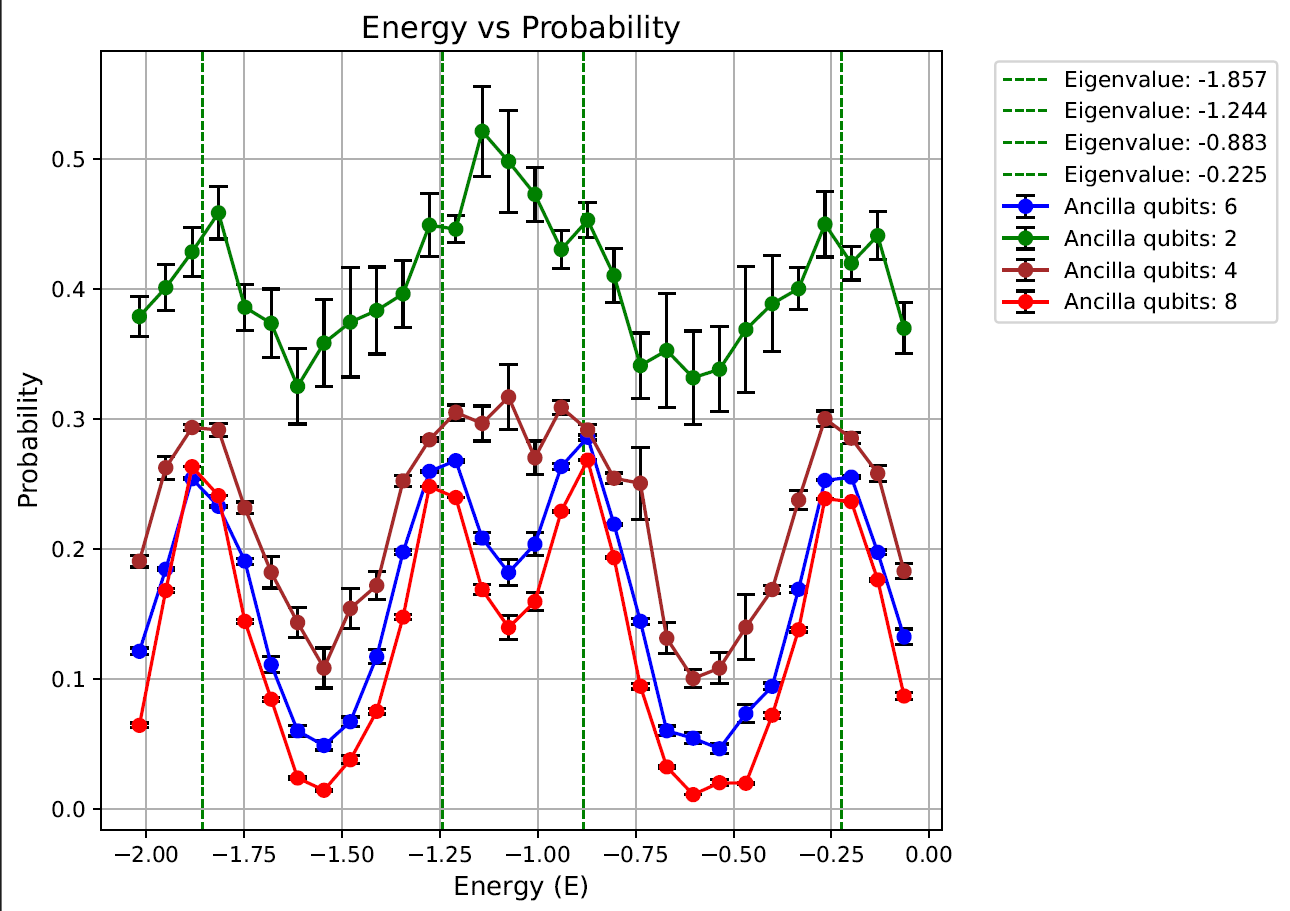

In this case the initial state vector to prepare was an equal superposition of the Eigenstates of the Hamiltonian, sigma=5, 30 Energies points were chosen and with the intervals E_min=-2.0178 and E_max=-0.0644. The number of ancillas were changed. 30 random batches were used.

### Part 2: Implementing the Rodeo Algorithm for a 6D Hamiltonian

In this part, you will extend the implementation of the Rodeo Algorithm to solve a more complex 6D Hamiltonian, which represents a reduced model of the water H₂O molecule.

The **goal is to find the five lowest energy levels of this Hamiltonian.**

---

In [22]:
import numpy as np

from classiq import *

np.random.seed(0)  # Please don't change

HAMILTONIAN_H2O = [
    PauliTerm([Pauli.I, Pauli.I, Pauli.I, Pauli.I, Pauli.I, Pauli.I], -12.533),
    PauliTerm([Pauli.Z, Pauli.I, Pauli.I, Pauli.Z, Pauli.I, Pauli.I], -1.276),
    PauliTerm([Pauli.Z, Pauli.Z, Pauli.I, Pauli.I, Pauli.I, Pauli.I], 0.627),
    PauliTerm([Pauli.I, Pauli.Z, Pauli.I, Pauli.I, Pauli.Z, Pauli.I], -0.875),
    PauliTerm([Pauli.I, Pauli.I, Pauli.Z, Pauli.Z, Pauli.I, Pauli.I], 0.452),
    PauliTerm([Pauli.X, Pauli.I, Pauli.X, Pauli.I, Pauli.I, Pauli.I], 0.182),
    PauliTerm([Pauli.I, Pauli.X, Pauli.I, Pauli.X, Pauli.I, Pauli.I], 0.139),
    PauliTerm([Pauli.Y, Pauli.Y, Pauli.I, Pauli.I, Pauli.I, Pauli.I], -0.047),
    PauliTerm([Pauli.Z, Pauli.I, Pauli.Z, Pauli.I, Pauli.Z, Pauli.I], 0.209),
    PauliTerm([Pauli.Z, Pauli.Z, Pauli.Z, Pauli.Z, Pauli.I, Pauli.I], -0.154),
    PauliTerm([Pauli.I, Pauli.Z, Pauli.I, Pauli.Z, Pauli.Z, Pauli.Z], 0.198),
    PauliTerm([Pauli.X, Pauli.I, Pauli.I, Pauli.I, Pauli.X, Pauli.I], 0.061),
    PauliTerm([Pauli.I, Pauli.I, Pauli.Y, Pauli.I, Pauli.Y, Pauli.I], -0.027),
    PauliTerm([Pauli.Z, Pauli.I, Pauli.Z, Pauli.Z, Pauli.I, Pauli.Z], 0.118),
]

In [23]:
### Your Code Goes Here ###
x_H2O = hamiltonian_to_matrix(HAMILTONIAN_H2O)
print(np.linalg.norm(x_H2O))
eigenvalues_H2O, eigenvectors_H2O = np.linalg.eigh(x_H2O)

# Sort and round eigenvalues and eigenvectors
sorted_indices_H2O = np.argsort(eigenvalues_H2O)
sorted_eigenvalues_H2O = np.round(eigenvalues_H2O[sorted_indices_H2O], 3)
sorted_eigenvectors_H2O = np.round(eigenvectors_H2O[:, sorted_indices_H2O], 3)

# Display results with better formatting
print("=== Sorted Eigenvalues ===")
for i, val in enumerate(sorted_eigenvalues_H2O):
    print(f"Eigenvalue {i + 1}: {val}")

print("\n=== Sorted Eigenvectors ===")
for i, vec in enumerate(sorted_eigenvectors_H2O.T):
    print(f"Eigenvector {i + 1}: {vec}")

101.27094809470292
=== Sorted Eigenvalues ===
Eigenvalue 1: -16.217
Eigenvalue 2: -16.057
Eigenvalue 3: -15.8
Eigenvalue 4: -15.639
Eigenvalue 5: -15.247
Eigenvalue 6: -14.829
Eigenvalue 7: -14.718
Eigenvalue 8: -14.666
Eigenvalue 9: -14.605
Eigenvalue 10: -14.506
Eigenvalue 11: -14.365
Eigenvalue 12: -14.301
Eigenvalue 13: -14.249
Eigenvalue 14: -14.187
Eigenvalue 15: -14.088
Eigenvalue 16: -14.08
Eigenvalue 17: -13.945
Eigenvalue 18: -13.844
Eigenvalue 19: -13.736
Eigenvalue 20: -13.647
Eigenvalue 21: -13.413
Eigenvalue 22: -13.318
Eigenvalue 23: -13.278
Eigenvalue 24: -13.254
Eigenvalue 25: -13.118
Eigenvalue 26: -13.113
Eigenvalue 27: -12.862
Eigenvalue 28: -12.837
Eigenvalue 29: -12.701
Eigenvalue 30: -12.7
Eigenvalue 31: -12.574
Eigenvalue 32: -12.407
Eigenvalue 33: -12.368
Eigenvalue 34: -12.309
Eigenvalue 35: -12.198
Eigenvalue 36: -12.185
Eigenvalue 37: -12.141
Eigenvalue 38: -11.994
Eigenvalue 39: -11.951
Eigenvalue 40: -11.874
Eigenvalue 41: -11.817
Eigenvalue 42: -11.781
Ei

In [ ]:

points_E=50
E_min=-16.662000000000003
E_max=-16.662000000000003+0.75*np.sqrt(sigma) 
E=np.linspace(E_min,E_max,points_E)




64
1.0


### Superposition Amplitudes for Rodeo Algorithm

This function generates the amplitudes of a superposition of the first few eigenstates of a Hermitian matrix, designed to be used as the initial state for the **Rodeo Algorithm**.

#### Purpose:
- The superposition serves as a starting point for the Rodeo Algorithm to isolate specific eigenstates efficiently.

#### Steps:
1. **Eigenstate Computation**:
   - Uses the **LOBPCG method** to approximate eigenvalues and eigenvectors quickly.

2. **Superposition Formation**:
   - Combines the first `num_eigenstates` eigenvectors into a single quantum state.

3. **Normalization**:
   - Ensures the superposition state is valid for quantum operations.

4. **Amplitude Calculation**:
   - Extracts the absolute values of the normalized superposition components.

This approach is efficient and prepares an initial state compatible with the Rodeo Algorithm's requirements. 

In [ ]:

from scipy.sparse.linalg import lobpcg

def compute_amplitudes(matrix, num_eigenstates=5):
    """
    Compute the amplitudes of the superposition of the first few eigenstates
    of a given Hermitian matrix in the computational basis.
    
    Parameters:
    - matrix (np.ndarray): Hermitian matrix
    - num_eigenstates (int): Number of eigenstates to compute for superposition
    
    Returns:
    - list: Amplitudes of the superposition in the computational basis
    """
    # Step 1: Compute eigenstates using LOBPCG
    n = matrix.shape[0]
    initial_guess = np.random.rand(n, num_eigenstates)  # Random initial guess
    eigenvalues, eigenvectors = lobpcg(matrix, initial_guess, largest=False)
    
    # Step 2: Form the superposition of the first `num_eigenstates` eigenstates
    superposition_state = np.sum(eigenvectors[:, :num_eigenstates], axis=1)
    
    # Step 3: Normalize the superposition state
    superposition_state /= np.linalg.norm(superposition_state)
    
    # Step 4: Compute amplitudes (absolute values of the components)
    amplitudes = np.abs(superposition_state).tolist()
    
    # Verify normalization
    assert np.isclose(np.sum(np.array(amplitudes)**2), 1), "The amplitudes are not normalized."
    
    return eigenvalues, amplitudes

# Example usage
# Compute amplitudes
approximate_eigenvalues_h20, amplitudes_h20 = compute_amplitudes(x_H2O, num_eigenstates=5)

amplitudes_hadamard=[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
        0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
        0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
        0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
        0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
        0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
        0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
        0.125]
print("Amplitudes:", amplitudes_h20)

In [ ]:
@qfunc
def main(ancillas: Output[QArray[QBit]], E:CReal, t: CArray[CReal,N]):
    
    # Allocate the number of ancilla qubits ( or number of cycles)
    allocate(N, ancillas)
    
    # Prepare initial state to perform the time evolution
    # Option 1 Prepare amplitudes : 
    #prepare_amplitudes(amplitudes=amplitudes, bound=0, out=state) #

    # Option 2 Implement a state that hassingle excitations for the water molecule: (As part of the chemical ansats or Hartree Fock trial states).
    # The circuit is the one in the Figure 1.
    state_2= QArray('state_2')
    allocate(3, state_2)
    state_1= QArray('state_1')
    allocate(3, state_1)
    X_transform(state_1)
    state=QArray('state')
    bind(source=[state_2,state_1], destination=state)
    within_apply(within= lambda: [Y(state[0]),hadamard_transform(state[0]),hadamard_transform(state[5]), Y(state[5]),
                                   repeat(count=state.len-1, iteration= lambda index: CX(state[index], state[index+1]))
                                  ],
                 apply= lambda: [U(0.3*np.pi, 0.4*np.pi,0.2*np.pi,0, state[5])])
    
    # Implement the Rodeo Algorithm
    rodeo_algorithm(HAMILTONIAN=HAMILTONIAN_H2O, ancillas=ancillas, state=state, E=E, t=t)

In [26]:

qmod = create_model(main)
qprog = synthesize(qmod)
execution_session = ExecutionSession(qprog)
#show(qprog)

Opening: https://platform.classiq.io/circuit/68f803cc-f7e5-420a-883c-557431a14abd?version=0.59.0


In [27]:
# Helper function to compute the probability of ancilla being |1...1>
def population(item):
    prob=0.0
    data=item.parsed_counts
    for h in range(len(data)):
        if (data[h].state['ancillas']==[1]*N):
            prob=data[h].shots / item.num_shots
    return prob

In [28]:
probabilities=[]
N_repetitions=50
for repetition in range(N_repetitions):
    tempus=[]
    for l in range(points_E):
        tempus.append(list(np.random.normal(mean,sigma,N)))
    batch_sample_job = execution_session.submit_batch_sample([{"E": e, "t": t} for e, t in zip(E, tempus)])
    job_id = batch_sample_job.id
    retrieved_job = ExecutionJob.from_id(job_id)
    probs_batch=[]

    for item in retrieved_job.get_batch_sample_result():
        prob_single_energy=population(item)
        probs_batch.append(prob_single_energy)

        # # Extract the specific dictionary
        # result = next((item for item in data if list(item.keys())[0]['ancillas'] == [1, 1, 1, 1]), None)

        # print(result)
    probabilities.append(probs_batch)

probabilities=np.array(probabilities)

In [ ]:
probs_mean=np.mean(probabilities,axis=0)
probs_std=np.var(probabilities,axis=0)
print('mean:',probs_mean)
print('sdt:',probs_std)
print('Energies:',E)
print('ancilla',N)

# Create a DataFrame
dataframe = {
    "Ancilla Count": [N] * len(E),   # Replicate N to match the length of E
    "Energies": E,                 # Independent variable
    "Mean Probability": probs_mean,  # Mean of probabilities
    "Variance": probs_std,          # Variance of probabilities
}

df = pd.DataFrame(dataframe)
output_path =""+str(N_repetitions)+"_amplitudes_best_min_energy_"+str(E_min)+"_max_energy_"+str(E_max)+".csv" 
# Display the DataFrame
df.to_csv(output_path, index=False, header=True, mode='a')

mean: [0.01233398 0.01907227 0.01996094 0.02172852 0.00985352 0.02316406
 0.0165332  0.0118457  0.01277344 0.01231445 0.01357422 0.01483398
 0.01332031 0.01118164 0.0122168  0.01635742 0.01177734 0.02126953
 0.01050781 0.01332031 0.02081055 0.0134375  0.01918945 0.02290039
 0.0128125  0.01245117 0.01601562 0.01341797 0.01389648 0.02956055
 0.01392578 0.0181543  0.02107422 0.01155273 0.01422852 0.02347656
 0.01828125 0.0153418  0.01014648 0.01364258 0.00857422 0.01866211
 0.02658203 0.01532227 0.01732422 0.01577148 0.01199219 0.01182617
 0.02742187 0.02208984]
sdt: [0.00040273 0.00368564 0.00187813 0.00293738 0.00107431 0.00279411
 0.0018135  0.00058096 0.00064328 0.0007878  0.00107572 0.00111847
 0.00071838 0.00036015 0.00068659 0.0007858  0.00060564 0.00169167
 0.00144592 0.00080901 0.00292396 0.00107193 0.00201123 0.00324085
 0.00045818 0.00121553 0.00213737 0.00057104 0.00119955 0.00588062
 0.00133126 0.00180506 0.00366944 0.0004229  0.00056811 0.00410295
 0.00147978 0.00141897 0.00

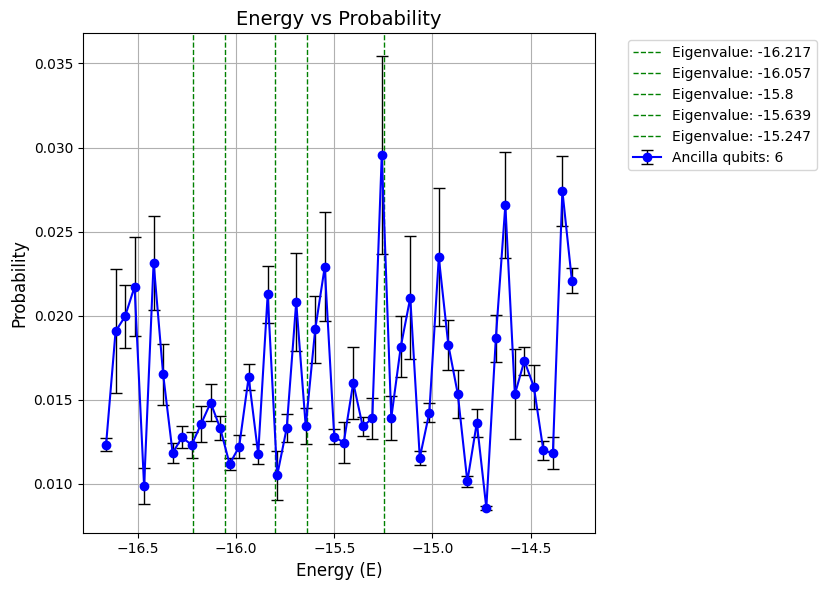

In [31]:
# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(E, probs_mean, yerr=probs_std, fmt='o', color='b',linestyle='-', ecolor='black', elinewidth=1, capsize=4, label="Ancilla qubits: 6")


for eigenvalue in sorted_eigenvalues_H2O[0:5]:
    plt.axvline(x=eigenvalue, color='g', linestyle='--', linewidth=1, label=f"Eigenvalue: {eigenvalue}")


# Adding labels and title
plt.xlabel("Energy (E)", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Energy vs Probability", fontsize=14)
plt.grid(True)
# Adding legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)

# Adjust the plot to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])


# Saving the plot to a specific folder
output_folder = "C:/Users/Marc/Documents/QST/QHackathon/Images"  # Change to your desired folder path
file_name = "H2O_energy_vs_probability_plot_joint_ancilla_q"+"_N_rep_"+str(N_repetitions)+"_min_energy_"+str(E_min)+"_max_energy_"+str(E_max)+"_points_E_"+str(points_E)+".pdf"
plt.savefig(f"{output_folder}/{file_name}", dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

The above data was created with the 6 ancilla qubits, and with sigma=10. The initial state was derived from the paper https://arxiv.org/pdf/1805. 04340 (Fig 1), as a chemical inspired state. The circuit for the state prepation is the following: ![WhatsApp Image 2024-12-01 at 06.57.47.jpeg](<attachment:WhatsApp Image 2024-12-01 at 06.57.47.jpeg>). The number of batches was 50.
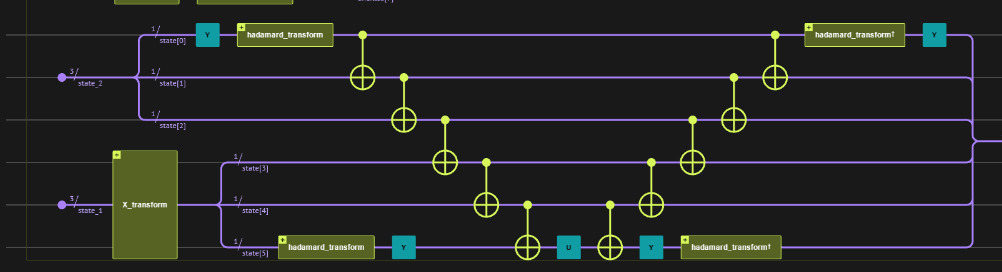

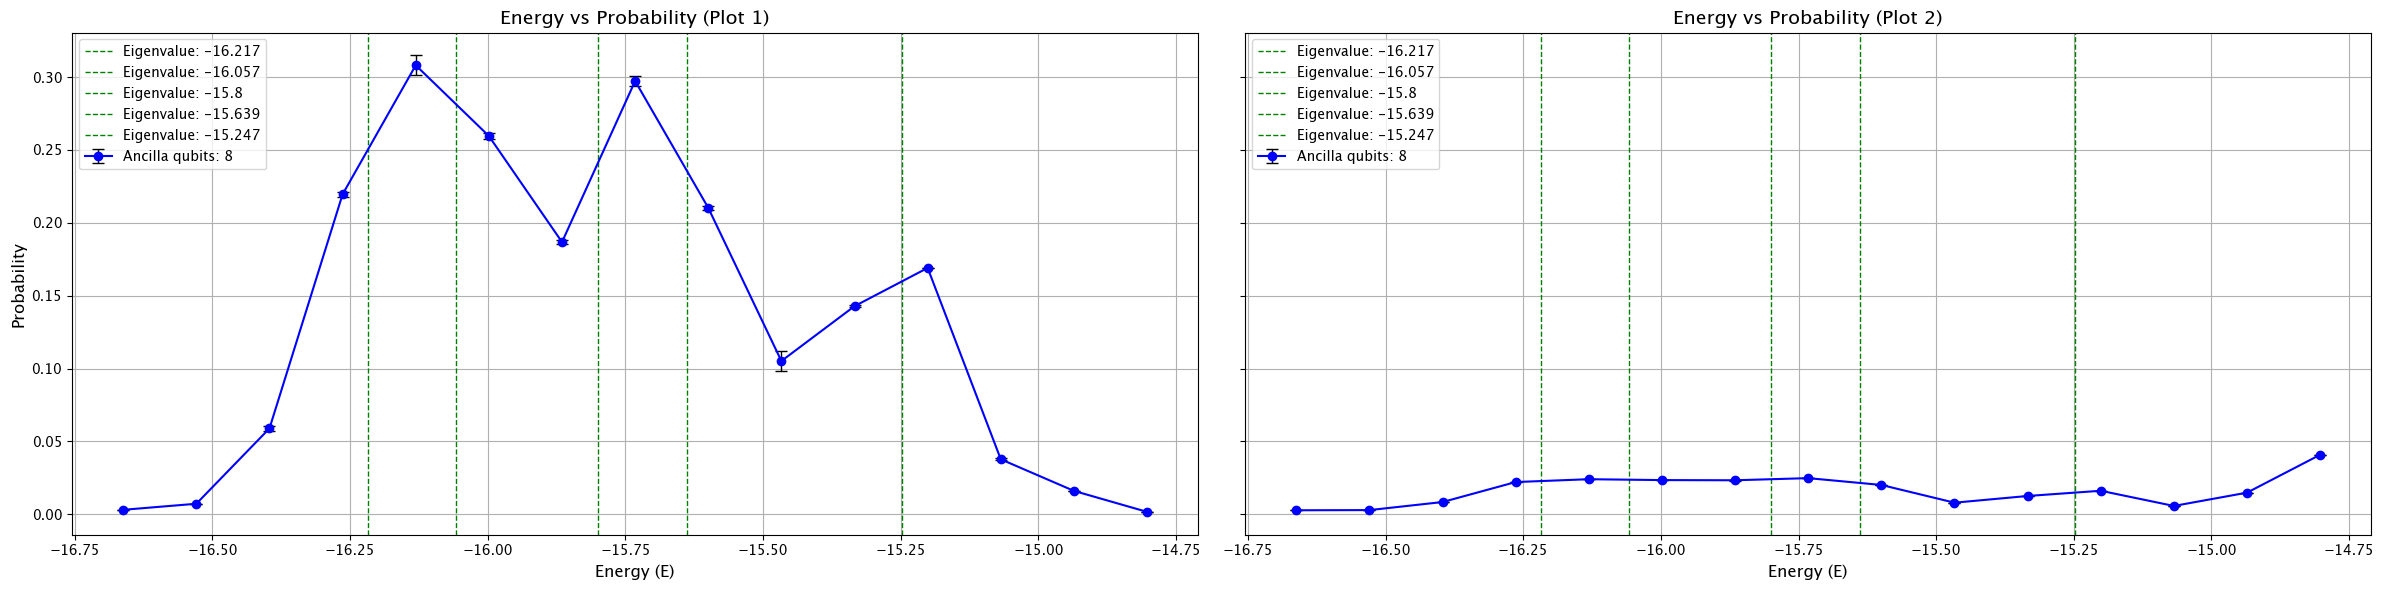


The sigma in the plost is sigma=5, and the number of ancilla qubits is 8. However, here we can see the effect on the initial state, as the one on the left is the state that is a superposition of the 5 ground states and the one left is an equal superposition. 12 random batches were used.